In [2]:
import pymc as pm
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

In [3]:
url = 'https://raw.githubusercontent.com/Jazli14/sta365/main/nfl_standings.csv'
df = pd.read_csv(url, index_col=0)

In [4]:
n, p = 638, 4
X = df.filter(items=['offensive_ranking','defensive_ranking', 'strength_of_schedule', 'margin_of_victory'])
Y = df.filter(items=['wins'])

In [5]:
len(df.index)

638

In [6]:
with pm.Model() as MLR:
    betas = pm.MvNormal('betas', mu=np.zeros((p,1)), cov=np.eye(p), shape=(p,1))
    sigma = pm.TruncatedNormal('sigma', mu=1, sigma=1, lower=0)
    Y = pm.Normal('y', mu=pm.math.dot(X, betas), sigma=sigma, observed=Y)

with MLR:
    idata = pm.sample()

/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Split-R-hats {'betas': array([[1.0012, 0.9999, 0.9992, 1.    ],
       [1.0008, 1.0003, 0.9992, 0.9997],
       [1.0009, 1.0005, 0.9994, 0.9999],
       [1.0013, 1.    , 0.9993, 0.9999]]), 'sigma': 0.9993} | 

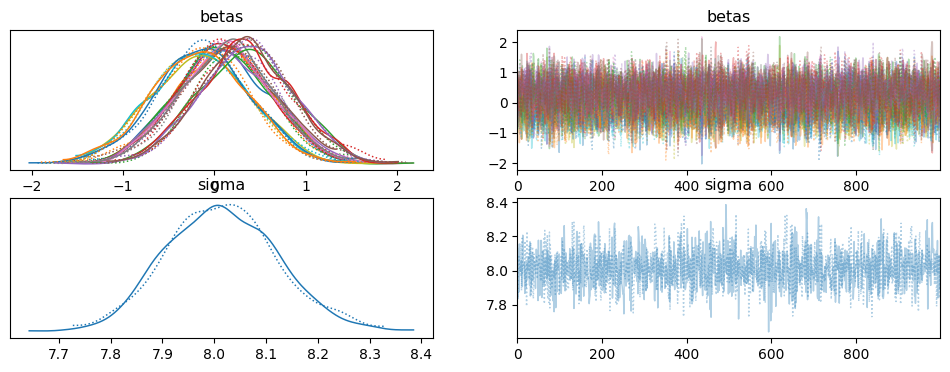

In [7]:
az.plot_trace(idata)
print("Split-R-hats", {k: np.round(v.values,4) for k,v in az.rhat(idata).items()}, end=' | ')

## Answer the following with respect to $p(\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y})$ on the previous slide



1. Rewrite $p(\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y})$ in terms of $\sigma^2$ (no longer using $\Sigma$) if $\Sigma=\sigma^2I$:

$$ p( \beta | \sigma, X, y) =
MVN(E[ \beta| \Sigma, X, y], Var[ \beta | \Sigma, X, y])$$
$$E[\beta | \Sigma, X, y] = Var(\beta | \Sigma, X, y)^{-1}(X^\top\Sigma^{-1}y + \Sigma^{-1}_\beta) \beta_0$$
$$E[\beta | \sigma^2I, X, y] = Var(\beta | \sigma^2I, X, y)^{-1}(X^\top(\sigma^2 I)^{-1}y + \Sigma^{-1}_\beta \beta_0$$

$$E[\beta | \sigma^2I, X, y] = Var(\beta | \sigma^2I, X, y)^{-1}(\sigma^{-2}(X^\top y) + \sigma^{-2}_\beta \beta_0)$$
$$Var(\beta | \sigma^2I, X, y) = [X^\top \Sigma^{-1}X]^{-1} + \Sigma_\beta^{-1}$$

$$Var(\beta | \sigma^2I, X, y) = [X^\top \sigma^{-2}X]^{-1} + \sigma_\beta^{-2}I$$
$$Var(\beta | \sigma^2I, X, y) = \sigma^{2}(X^\top X)^{-1} + \sigma_\beta^{-2}I$$
$$
\Rightarrow p(\beta | \Sigma, X, y) = MVN\bigg(\Big([\sigma^{2}(X^\top X)^{-1} + \sigma_\beta^{-2}I]^{-1} (\sigma^{-2}(X^\top y) + \sigma^{-2}_\beta \beta_0) \Big), \Big(\sigma^{2}(X^\top X)^{-1} + \sigma_\beta^{-2}I\Big) \bigg)
$$

Since $\Sigma^{-1} = \frac{1}{\sigma^2}$, then we can rewrite $p(\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y})$

$\Rightarrow p(\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}) = \mathcal{MVN}\bigg(E[\boldsymbol \beta | \boldsymbol\Sigma, \mathbf{X},\mathbf{y}]= (\mathbf{X}^\top \frac{1}{\sigma^2} \mathbf{X})^{-1}\mathbf{X}^\top \frac{1}{\sigma^2}\mathbf{y}, \text{Var}[\boldsymbol \beta | \boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = \mathbf{X}^{\top} \frac{1}{\sigma^2} \mathbf{X} \bigg) $


2. What is $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$?

From the above derivation we can identify that

$$E[\beta | \Sigma, X, y] = E[\beta | \sigma^2 I, X, y]
= [\sigma^{2}(X^\top X)^{-1} + \sigma_\beta^{-2}I]^{-1} (\sigma^{-2}(X^\top y) + \sigma^{-2}_\beta \beta_0)
$$

3. What ***hyperparameters*** values (legal or illegal) would make $E[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = (\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$?

To achieve $E[\beta | \Sigma, X, y] = (X^\top X)^{-1}X^{\top y}$

Therefore we require $(X^\top X)^{-1}$ must equal $[\sigma^{-2}(X^\top X) + \Sigma^{-2}_\beta I]^{-1}$

$\Rightarrow \sigma^{-2}_\beta = 0$

$(X^\top X)^{-1}$ must equal $[\sigma^{-2}(X^\top X)]^{-1} = \sigma^2(X^\top X)^{-1}$

$\Rightarrow \sigma^{2} = 1$

As $\sigma = -1$ is not a legal hyperparameter the only possible value would be for $\sigma = 1$

Then we also must require $X^\top y = \sigma^{-2}(X^\top y) + \sigma^{-2}_\beta \beta_0$

As defined above we already know $\sigma^{-2}_\beta = 0$ and therefore know that $\sigma = 1$


4. What ***hyperparameters*** values (legal or illegal) would make $E[  \mathbf{\hat y} = \mathbf{X}\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}] = \mathbf{X}(\mathbf{X^\top X})^{-1}\mathbf{X^\top y}$?

To achieve $E[{\hat y} = X \beta |\Sigma, X,y] = X(X^\top X)^{-1}X^\top y$

We want $X(X^\top X)^{-1} X^\top y$

$\Rightarrow (X^\top X)^{-1}[\sigma^2(X^\top X)^{-1} + \sigma^{-2}_\beta I]$

and $\Rightarrow X^\top y = [\sigma^{-2}(X^\top y) + \sigma^{-2}_\beta]$

Like in the previous question 3, we can see that we still need $\sigma^{2} = 1$ and $\sigma_\beta^{-2} = 0$


5. What is $\text{Var}[\boldsymbol \beta |\boldsymbol\Sigma, \mathbf{X},\mathbf{y}]$?

From the derivation in question 1 we can identify that
$$
Var[\beta | \Sigma, X, y] = Var(\beta | \sigma^2I, X, y) = \sigma^{2}(X^\top X)^{-1} + \sigma_\beta^{-2}I
$$


# Part III

I'll be using the same dataset in Part I

In [14]:
y = np.array(df.filter(items=['points_differential', 'points_for', 'points_against', 'simple_rating']))
n=len(y)
p= 4
# 'points_differential', 'points_for', 'points_against', 'simple_rating'
with pm.Model() as MNV_LKJ:
    packed_L = pm.LKJCholeskyCov("packed_L", n=p, eta= 1.0,
                                 sd_dist=pm.Exponential.dist(1.0, shape=p), compute_corr=False)
    L = pm.expand_packed_triangular(p, packed_L)
    Sigma = L.dot(L.T)
    mu = pm.MvNormal('mu', mu=np.array(3), cov=np.eye(p), shape=p);
    y = pm.MvNormal('y', mu=mu, cov=Sigma, shape=(n,1), observed=y)

with MNV_LKJ:
    idata2 = pm.sample()
